<a href="https://www.kaggle.com/code/ibrahimnibrahim/toyota-stock-test-mae-0-05?scriptVersionId=244287049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toyota-motors-stock-data-2980-2024/Toyota_Data.csv


In [2]:
#helper functions:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)
    return dataset

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(15, 10))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)


    plt.title(title)
    plt.grid(True)
    plt.show()

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

In [3]:
data_dir='/kaggle/input/toyota-motors-stock-data-2980-2024/Toyota_Data.csv'
df=pd.read_csv(data_dir)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11291 non-null  object 
 1   Adj Close  11291 non-null  float64
 2   Close      11291 non-null  float64
 3   High       11291 non-null  float64
 4   Low        11291 non-null  float64
 5   Open       11291 non-null  float64
 6   Volume     11291 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 617.6+ KB


In [5]:
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = df["Close"]
dataset = pd.DataFrame(dataset)


scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

train_set, test_set = train_test_split(scaled_data, test_size=0.2, shuffle=False)

In [6]:
time_step=np.arange(0,len(train_set))
# train_set is a numpy array, access it using numerical index 
close=train_set[:,0] # Access all rows and the first (and only) column
valid_x=np.arange(len(train_set),len(train_set)+len(test_set))
# test_set is also a numpy array
valid_y=test_set[:,0] # Access all rows and the first (and only) column


all_close=np.concatenate((close,valid_y))
all_time=np.concatenate((time_step,valid_x))

(test_set.shape,train_set.shape)

((2259, 1), (9032, 1))

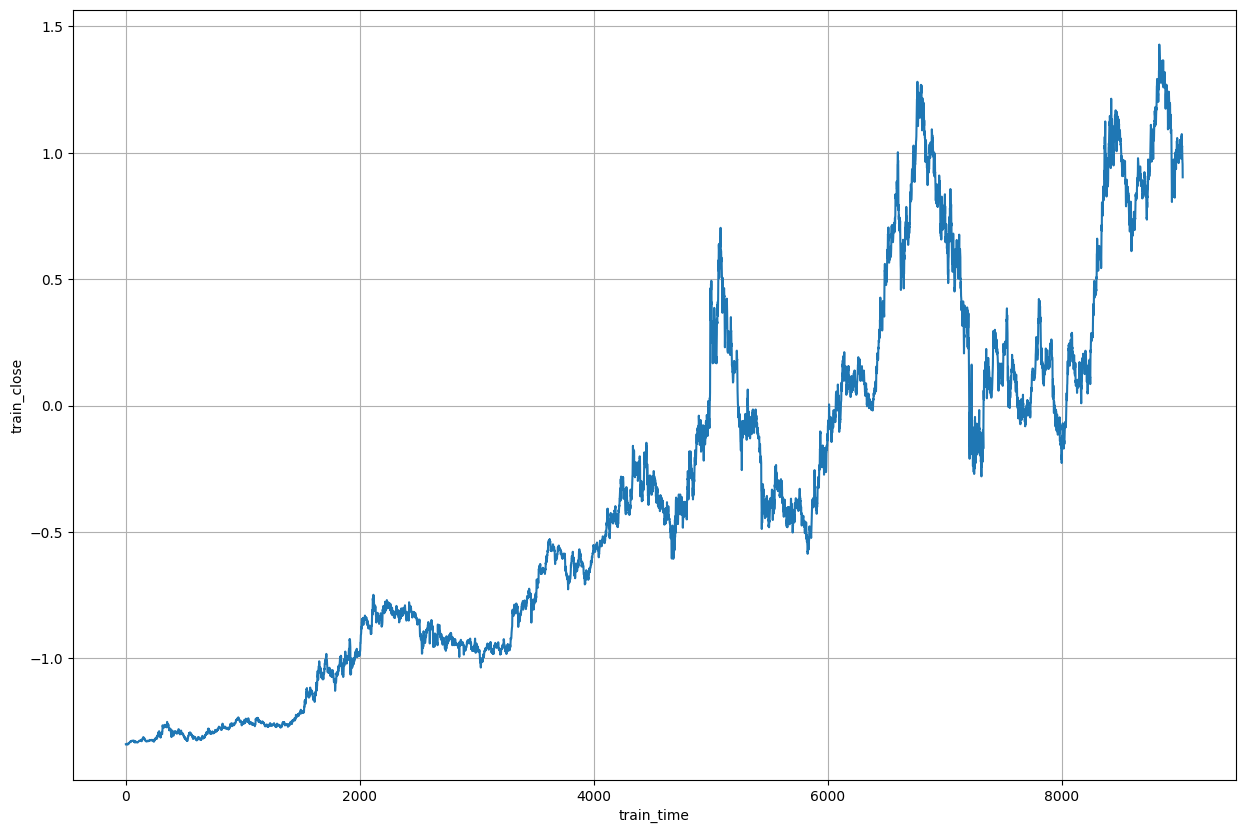

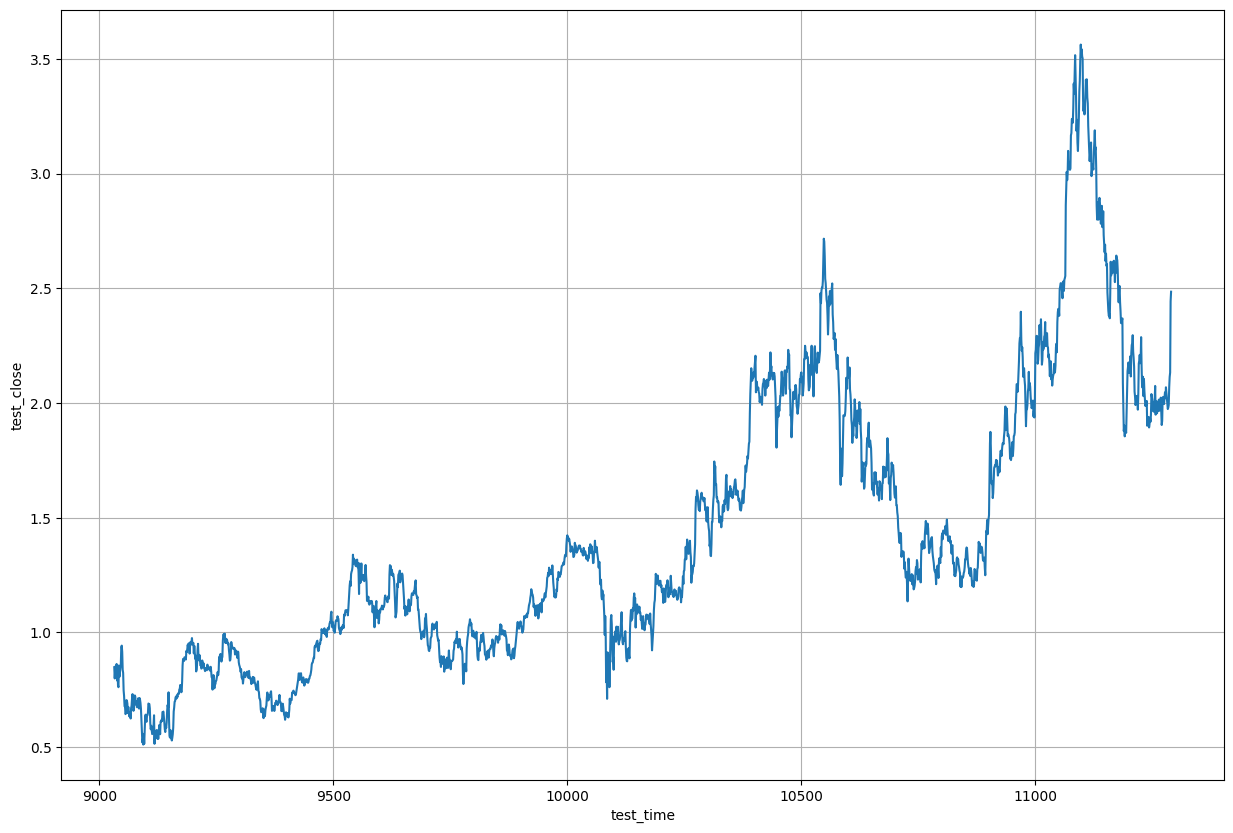

In [7]:
import matplotlib.pyplot as plt

# time_step=time_step[1500:]
# close=close[1500:]

plot_series(time_step,close, xlabel='train_time', ylabel='train_close')
plot_series(valid_x,valid_y, xlabel='test_time', ylabel='test_close')

In [8]:
import tensorflow as tf

# Parameters
window_size = 10
batch_size = 16
shuffle_buffer_size = 5000

# Generate the dataset windows
train_set = windowed_dataset(close, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(valid_y, window_size, batch_size, shuffle_buffer_size)

In [9]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

 # Print the model summary 
model.summary()
init_weights = model.get_weights()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,611 (674.26 KB)

 Trainable params: 172,611 (674.26 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# for SGD

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))


# optimizer = tf.keras.optimizers.SGD(momentum=0.9)
# loss=tf.keras.losses.Huber()


# model.compile(loss=loss, optimizer=optimizer)

# # Train the model
# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [11]:
# import numpy as np

# # Define the learning rate array
# lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# # Set the figure size
# plt.figure(figsize=(15, 10))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 0.01])

In [12]:
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Set the learning rate
# learning_rate = 9.88e-04

# Set the optimizer 
# if you want to use SGD i studed the learning rate TOP
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [13]:
history = model.fit(train_set,epochs=30)

Epoch 1/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1404 - mae: 0.2239
Epoch 2/30
 16/564 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.5977e-04 - mae: 0.0260

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.9012e-04 - mae: 0.0296
Epoch 3/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.9166e-04 - mae: 0.0250
Epoch 4/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.8066e-04 - mae: 0.0269
Epoch 5/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.7183e-04 - mae: 0.0259
Epoch 6/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.4487e-04 - mae: 0.0221
Epoch 7/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.0941e-04 - mae: 0.0241
Epoch 8/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.1426e-04 - mae: 0.0209
Epoch 9/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.0921e-04 - mae: 0.0238
Epoch 10/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0126 - mae: 0.0960
Epoch 11/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.8968e-04 - mae: 0.0273
Epoch 12/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.5952e-04 - mae: 0.0279
Epoch 13/30
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.80

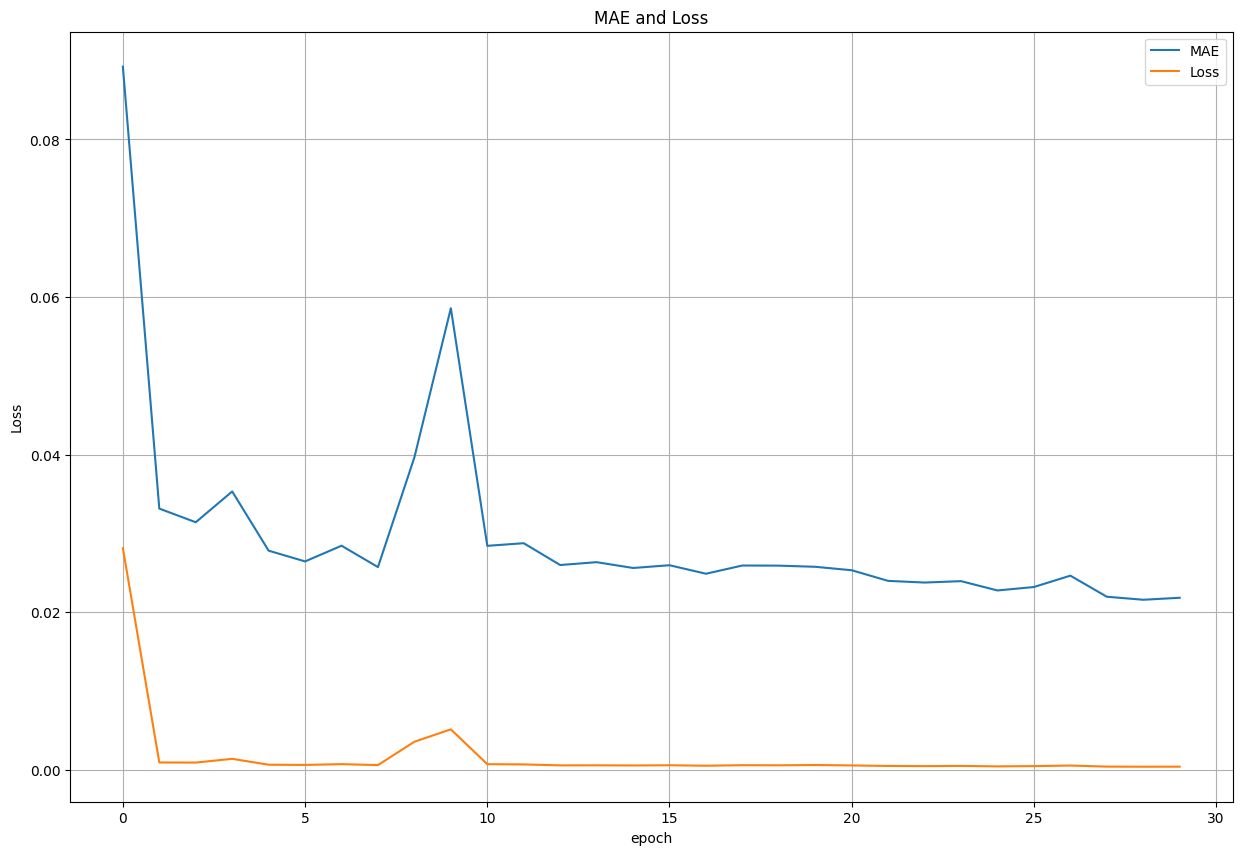

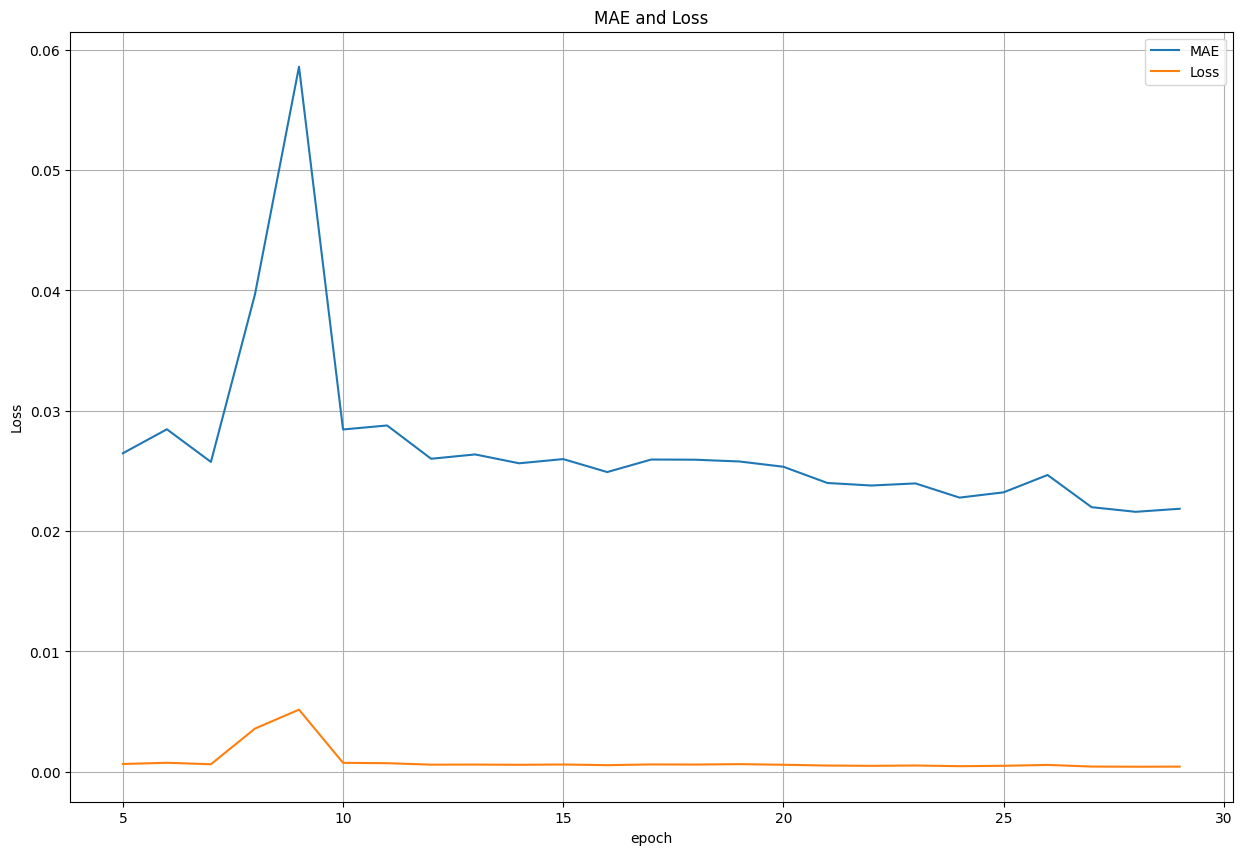

In [14]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

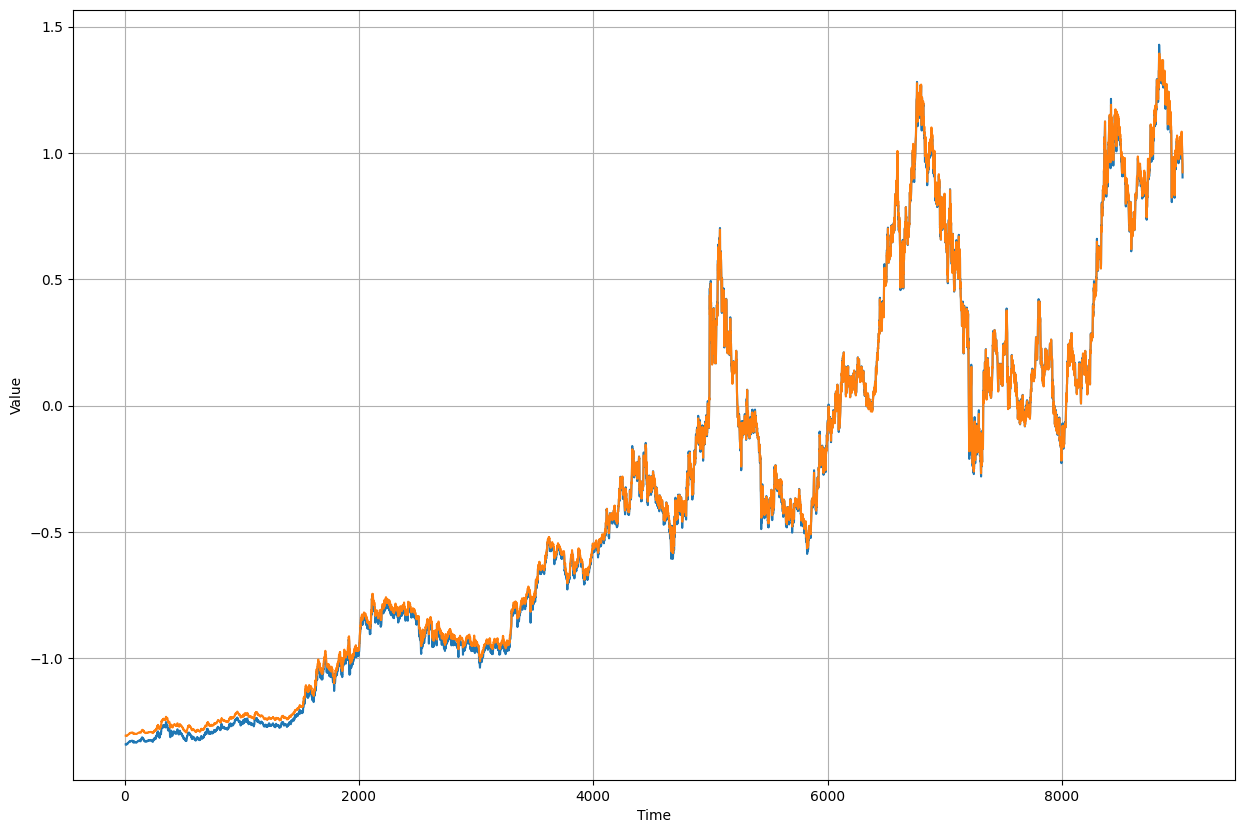

In [15]:
# Reduce the original series
forecast_series = close

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
plot_series(time_step[window_size-1:],(close[window_size-1:],results), xlabel='Time', ylabel='Value')

mae_all=tf.keras.metrics.mae(close[window_size-1:], results).numpy()

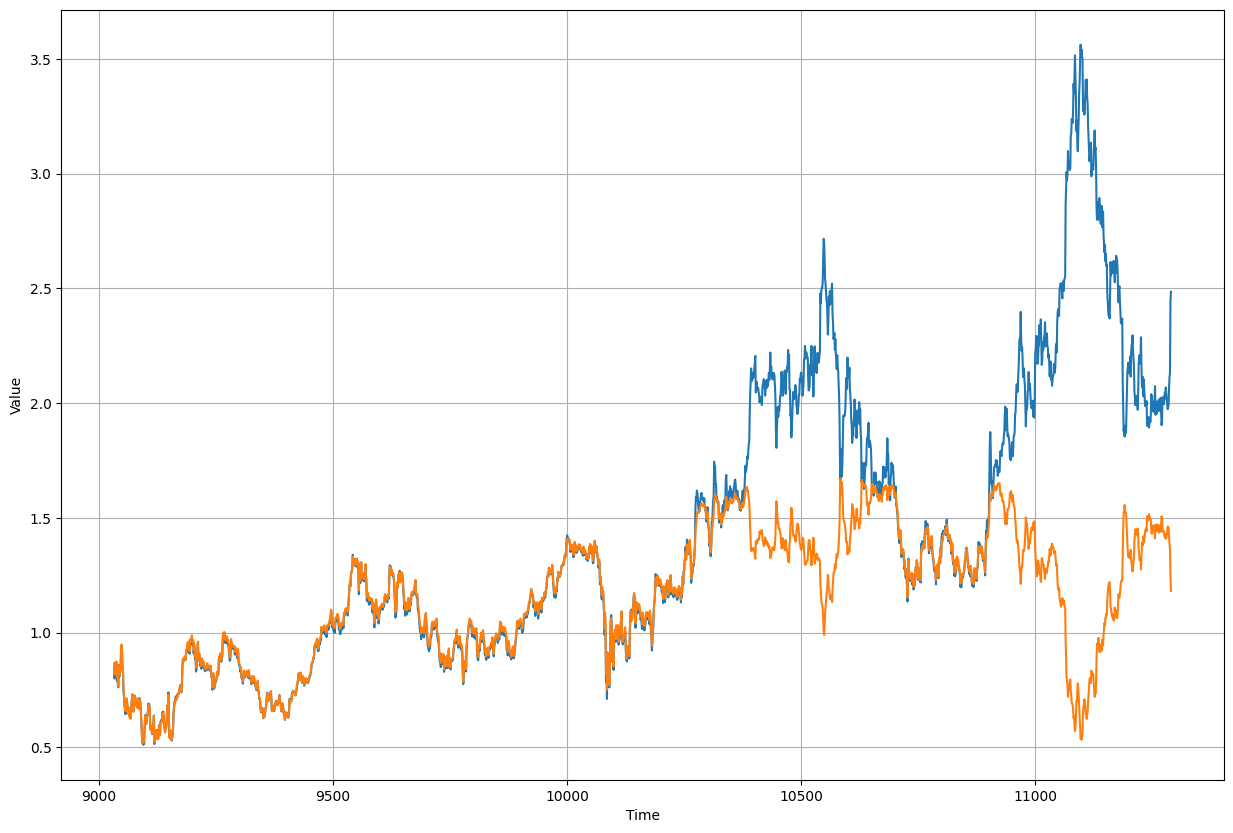

In [16]:
# Reduce the original series
forecast_series = all_close

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results

plot_series(all_time[-2259:],(forecast_series[-2259:],results[-2259:]), xlabel='Time', ylabel='Value')


mae_test=tf.keras.metrics.mae(valid_y, results[-2259:]).numpy()

In [17]:
print(f'MAE for all the dataset: {mae_all}')
print(f'MAE for the validation dataset: {mae_test}')

MAE for all the dataset: 0.012732645496726036
MAE for the validation dataset: 0.27646172046661377
